In [1]:
!pip install -U git+https://github.com/Sakib323/AI-Game-Engine.git
!pip install -U git+https://github.com/Sakib323/matmulfreellm.git

  Cloning https://github.com/Sakib323/AI-Game-Engine.git to /tmp/pip-req-build-gafw0grt
  Running command git clone --filter=blob:none --quiet https://github.com/Sakib323/AI-Game-Engine.git /tmp/pip-req-build-gafw0grt
  Resolved https://github.com/Sakib323/AI-Game-Engine.git to commit 8a2dc3d86df627f4fd0c82665eafa2b264033dc2
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:

In [3]:
import torch as th
import numpy as np
from diffusion_model import GaussianDiffusion, ModelMeanType, ModelVarType, LossType, get_named_beta_schedule
from diffusers import AutoencoderKL
import matplotlib.pyplot as plt

device = "cuda" if th.cuda.is_available() else "cpu"
vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="vae").to(device)
vae.eval()

num_timesteps = 1000
betas = get_named_beta_schedule("linear", num_timesteps)
diffusion = GaussianDiffusion(
    betas=betas,
    model_mean_type=ModelMeanType.EPSILON,
    model_var_type=ModelVarType.FIXED_SMALL,
    loss_type=LossType.MSE
)

batch_size, channels, height, width = 8, 3, 256, 256
x_start = th.randn((batch_size, channels, height, width), device=device)
x_start = th.clamp(x_start, -1, 1)
with th.no_grad():
    latent_dist = vae.encode(x_start).latent_dist
    latent = latent_dist.sample() * vae.config.scaling_factor
t = th.tensor([500] * batch_size, device=device, dtype=th.long)
noise = th.randn_like(latent)
x_noisy = diffusion.q_sample(x_start=latent, t=t, noise=noise)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Original image shape: torch.Size([8, 4, 256, 256])
Noisy image shape: torch.Size([8, 4, 256, 256])
Sample original values (first image, first channel, top-left 2x2):
tensor([[1.0000, 1.0000],
        [0.8309, 0.3379]], device='cuda:0')
Sample noisy values (first image, first channel, top-left 2x2):
tensor([[-0.4095,  0.3912],
        [ 1.3377,  0.8238]], device='cuda:0')


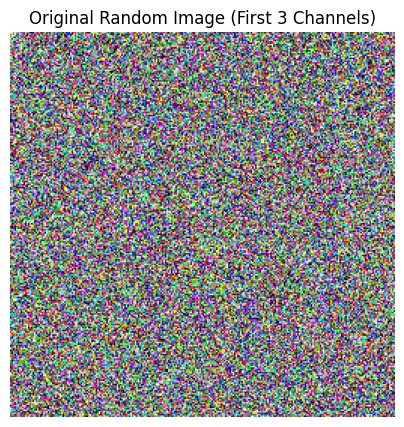

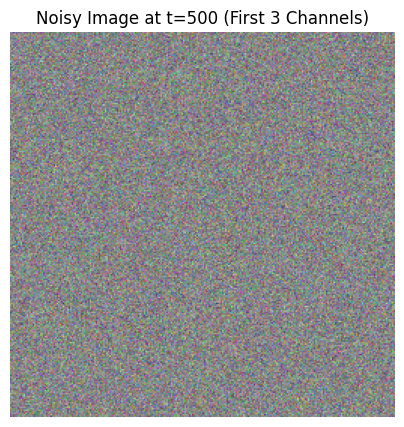

In [5]:
import torch
import numpy as np
from diffusion_model import GaussianDiffusion, ModelMeanType, ModelVarType, LossType, get_named_beta_schedule

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_timesteps = 1000
betas = get_named_beta_schedule("linear", num_timesteps)
diffusion = GaussianDiffusion(
    betas=betas,
    model_mean_type=ModelMeanType.EPSILON,
    model_var_type=ModelVarType.FIXED_SMALL,
    loss_type=LossType.MSE
)

batch_size, channels, height, width = 8, 4, 256, 256
x_start = torch.randn((batch_size, channels, height, width), device=device)

# Normalize to [-1, 1] range (optional, assuming input images are expected in this range)
x_start = torch.clamp(x_start, -1, 1)

# Choose a timestep for the forward process (e.g., t=500 for significant noise)
t = torch.tensor([500] * batch_size, device=device, dtype=torch.long)

# Apply the forward process to add noise
noise = torch.randn_like(x_start)  # Generate random noise
x_noisy = diffusion.q_sample(x_start=x_start, t=t, noise=noise)

print(f"Original image shape: {x_start.shape}")
print(f"Noisy image shape: {x_noisy.shape}")
print(f"Sample original values (first image, first channel, top-left 2x2):\n{x_start[0, 0, :2, :2]}")
print(f"Sample noisy values (first image, first channel, top-left 2x2):\n{x_noisy[0, 0, :2, :2]}")

import matplotlib.pyplot as plt
def show_image(tensor, title="Image"):
    # Convert to CPU and numpy, take first image from batch, and first 3 channels for RGB visualization
    img = tensor[0, :3, :, :].cpu().numpy().transpose(1, 2, 0)  # [H, W, C]
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1] for display
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

show_image(x_start, title="Original Random Image (First 3 Channels)")
show_image(x_noisy, title="Noisy Image at t=500 (First 3 Channels)")

In [ ]:
#Pathify



In [ ]:
Ternery DIT

In [ ]:
RMS NORM

In [ ]:
LINEAR AND RESHAPE

In [ ]:
DECODER VAE TO REMOVE NOISE